In [5]:
from google.colab import drive
drive.mount('/content/drive/')

#### check for gpu
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)

get_available_gpus()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7639691326899411159
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17963089613816183249
physical_device_desc: "device: XLA_CPU device"
]


In [6]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from scipy import signal

In [7]:
root = '/content/drive/My Drive/DNAChallenge/'
trainFeatures = root + 'train_values.csv'
trainLabels = root + 'train_labels.csv'
testFeatures = root + 'test_values.csv'
submission = root + 'submission.csv'

In [8]:
x_train = pd.read_csv(trainFeatures)
y_train = pd.read_csv(trainLabels)

x_test = pd.read_csv(testFeatures)
target = [x for x in y_train.columns if 'sequence' not in x]

In [9]:
x_train = x_train.set_index('sequence_id').join(y_train.set_index('sequence_id'))

In [10]:
print(x_train)

                                                      sequence  ...  ZZJVE4HO
sequence_id                                                     ...          
9ZIMC        CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...  ...       0.0
5SAQC        GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...  ...       0.0
E7QRO        NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...  ...       0.0
CT5FP        GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...  ...       0.0
7PTD8        CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...  ...       0.0
...                                                        ...  ...       ...
BOQSD        AACAAAATATTAACGCTTACAATTTCCATTCGCCATTCAGGCTGCG...  ...       0.0
5XVVU        AACAAAATATTAACGCTTACAATTTCCATTCGCCATTCAGGCTGCG...  ...       0.0
CVGHF        CCGGTGGTGCATATCGGGGATGAAAGCTGGCGCATGATGACCACCG...  ...       0.0
ZVT1A        CTAGCTAGTCCTGCAGGTTTAAACGAATTCGCCCTTTGCTTTCTCT...  ...       0.0
U5MR3        TGGCGAATGGGACGCGCCCTGTAGCGGCGCATTAAGCGCGGCGGGT...  

In [102]:
seqs = []
targets = []
for i , row in x_train.iterrows():

    if len(row['sequence'].replace('N', '')) < 500:
      continue
    else:
      seqs.append(row['sequence'].replace('N', '')[0:500])
      targets.append(row[target])


In [103]:
print(len(seqs))
print(len(targets))

62426
62426


In [104]:
def getKmers(text, size):
    return [text[x:x+size].upper() for x in range(len(text) - size + 1)]

kmer = 5
kmer_texts = [' '.join(getKmers(i, kmer)) for i in seqs]

In [105]:
print(len(kmer_texts[6].split(' ')))
print(len(kmer_texts[7].split(' ')))

496
496


In [106]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [107]:
cv = CountVectorizer()
X = cv.fit_transform(kmer_texts)

In [133]:
print(len(cv.get_feature_names()))

1024


In [109]:
X = np.int32(X.toarray())


(62426, 1024)


In [117]:
targets = np.array(targets)

In [127]:
print(X.shape)
print(targets.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    targets, 
                                                    test_size = 0.2, 
                                                    random_state=42)

(62426, 1024)
(62426, 1314)


In [149]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

print(type(X_train))
print(type(X_test))
print(type(Y_train))
print(type(Y_test))

X_train = X_train.astype(int)
X_test = X_test.astype(int)
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

(49940, 1024)
(12486, 1024)
(49940, 1314)
(12486, 1314)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [153]:
model = tf.keras.Sequential([ tf.keras.layers.Embedding(1000, 64, input_length=1024),
         tf.keras.layers.Conv1D(filters = 8, kernel_size = 5, activation = 'relu'),
         tf.keras.layers.MaxPooling1D(pool_size = 2),       
         tf.keras.layers.Conv1D(filters = 8, kernel_size = 5, activation = 'relu'),
         tf.keras.layers.MaxPooling1D(pool_size = 2),  
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(64, activation='relu'),
         tf.keras.layers.Dense(1314, activation = 'softmax')])

model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(1e-3), metrics = ['categorical_accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1024, 64)          64000     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1020, 8)           2568      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 510, 8)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 506, 8)            328       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 253, 8)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)               

In [154]:
history = model.fit(X_train, Y_train, epochs = 50, validation_data=((X_test, Y_test)), batch_size = 256)

Epoch 1/50
196/196 [==============================] - 105s 537ms/step - loss: 5.4568 - categorical_accuracy: 0.1998 - val_loss: 4.6569 - val_categorical_accuracy: 0.2850
Epoch 2/50
196/196 [==============================] - 105s 534ms/step - loss: 4.0908 - categorical_accuracy: 0.3405 - val_loss: 3.7965 - val_categorical_accuracy: 0.3725
Epoch 3/50
196/196 [==============================] - 104s 530ms/step - loss: 3.3866 - categorical_accuracy: 0.4120 - val_loss: 3.4288 - val_categorical_accuracy: 0.4235
Epoch 4/50
196/196 [==============================] - 105s 537ms/step - loss: 2.9944 - categorical_accuracy: 0.4543 - val_loss: 3.2618 - val_categorical_accuracy: 0.4402
Epoch 5/50
196/196 [==============================] - 104s 531ms/step - loss: 2.7379 - categorical_accuracy: 0.4814 - val_loss: 3.1803 - val_categorical_accuracy: 0.4568
Epoch 6/50
196/196 [==============================] - 105s 535ms/step - loss: 2.5504 - categorical_accuracy: 0.5030 - val_loss: 3.1128 - val_categoric

KeyboardInterrupt: ignored

In [ ]:
#### helper plot function
def plot_acc_loss(history):
  plt.plot(history.history['categorical_accuracy'], label='acc')
  plt.plot(history.history['val_categorical_accuracy'], label='val_acc')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()


  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_los')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
plot_acc_loss(history)

In [31]:
toDrop = []

for idx, row in x_train.iterrows():
    if len(row['sequence']) > 1000:
        toDrop.append(idx)

x_train.drop(toDrop, inplace=True)

In [32]:
print(x_train)

                                                      sequence  ...  ZZJVE4HO
sequence_id                                                     ...          
5SAQC        GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...  ...       0.0
CT5FP        GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...  ...       0.0
XZ42B        GAAAGCTGAGCCTGCGACTCCCGCAGAAGCGGCGCAAAGCGACCGC...  ...       0.0
R95QA        TCGCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGC...  ...       0.0
N4W48        TCGGATCTGATCAAGGTCGTGGGATCCCCGGAATTCCCGGGTCGAC...  ...       0.0
...                                                        ...  ...       ...
FJEH1        CATGCATCTCTCAGTGCACTAAAGGGGGGATCCGATCTCAATATGA...  ...       0.0
QLFUH        GCAACGGAATATCTTAGTGCACTAAGGGGGGATCCGATCTCAATAT...  ...       0.0
X4YHQ        CGAGGGAATCTCTCAGTGCACTAAAGGGGGGATCCGATCTCAATAT...  ...       0.0
Y0TSM        CCATTGGATCTCTCAGTGCACTAAGGGGGGATCCGATCTCAATATG...  ...       0.0
59BNF        ATGCCTGGTCCGACCCCCAGTGGCACTAACGTGGGATCCTCAGGGC...  

In [7]:
tmpDict = {}
toDrop = []

v = np.argmax(x_train[target].values, axis=1)

counter=0
for idx, row in x_train.iterrows():
  f = target[v[counter]]

  if f not in tmpDict:
    tmpDict[f] = 1
  else:
    if tmpDict[f] < 51:
      tmpDict[f] += 1
    else:
      if idx not in toDrop:
        toDrop.append(idx)
  counter += 1
x_train.drop(toDrop, inplace=True)

In [8]:
print(x_train)

                                                      sequence  ...  ZZJVE4HO
sequence_id                                                     ...          
9ZIMC        CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...  ...       0.0
5SAQC        GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...  ...       0.0
E7QRO        NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...  ...       0.0
CT5FP        GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...  ...       0.0
7PTD8        CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...  ...       0.0
...                                                        ...  ...       ...
BOQSD        AACAAAATATTAACGCTTACAATTTCCATTCGCCATTCAGGCTGCG...  ...       0.0
5XVVU        AACAAAATATTAACGCTTACAATTTCCATTCGCCATTCAGGCTGCG...  ...       0.0
CVGHF        CCGGTGGTGCATATCGGGGATGAAAGCTGGCGCATGATGACCACCG...  ...       0.0
ZVT1A        CTAGCTAGTCCTGCAGGTTTAAACGAATTCGCCCTTTGCTTTCTCT...  ...       0.0
U5MR3        TGGCGAATGGGACGCGCCCTGTAGCGGCGCATTAAGCGCGGCGGGT...  

In [364]:
'''
start = 'ATG'
stop = ['TAA, TAG, TGA']

def get_sequences(text):
    goodSeq = []
    badSeq = []

    l = len(text)
    counter = 0

    idx1 = 0
    idx2 = 0

    while counter < l:
      idx2 = text[idx1:].find(start)
      print(idx1, idx2)

      badSeq.append(text[idx1:idx2])
      gSeq = text[idx2:idx2+3]

      tmpIdx = idx2+3

      while text[tmpIdx:tmpIdx+3] not in stop:
        gSeq += text[tmpIdx:tmpIdx+3]
        print(text[tmpIdx:tmpIdx+3])
        tmpIdx += 3


      counter += 500

    return goodSeq, badSeq
'''

"\nstart = 'ATG'\nstop = ['TAA, TAG, TGA']\n\ndef get_sequences(text):\n    goodSeq = []\n    badSeq = []\n\n    l = len(text)\n    counter = 0\n\n    idx1 = 0\n    idx2 = 0\n\n    while counter < l:\n      idx2 = text[idx1:].find(start)\n      print(idx1, idx2)\n\n      badSeq.append(text[idx1:idx2])\n      gSeq = text[idx2:idx2+3]\n\n      tmpIdx = idx2+3\n\n      while text[tmpIdx:tmpIdx+3] not in stop:\n        gSeq += text[tmpIdx:tmpIdx+3]\n        print(text[tmpIdx:tmpIdx+3])\n        tmpIdx += 3\n\n\n      counter += 500\n\n    return goodSeq, badSeq\n"

In [241]:
'''
a, b = get_sequences('NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAGAAGCGGCGCAAAGCGACCGCCACAGCCTGCTGGAGCACAGCCGCGAGTTCTTGGACTTCTTCTGGGACATTGCGAAACCGGATCAGGAAACGCGGCTCCGGGCCACGGAGAANTTGTTGGAGTACTTGCNCACAAGGCCCAATGATTCGGAAATGAAATATGCCCTGAANCGCCTAATCACTGGGCTTGNGNTNNNNCGANNANGCGGNNNNNGGGGGTGANGNGNNGGCTGNNNNGGGNNNNGGAANNGGGGGAGGGNAGGGGGNANGGGGGNGGGGGGANGGAGGGGNAGGGGGGGGGGGGGGTGGGAGGNGNNGAGGGGGGAGGGAAGAGGGGGGGGGGGAGGGAGGGGGGAGGGAGGGGAGGGGGGGNGAGGGGGAGAGGAAAAGAGGGAGGGGGGAGGGAGGGGGGGGAGGGGGGGGTGGGGGGGGGGGGGGGAGGGGGGGAGGGGGTGGAGGGGGGGGAGGAGGGGGGGGGGGGGGGGGGGGGAGGGGGGGGGGGGGGGGGGAGGGGGGGGGGGAGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGAAGGGGGAGGGGAGGGGGGGGGGGGGGGGGGGAGAGAGGGGGGGGGGGGGGGGGGGGGTGGGGGGGGGGGGAGGGGGGGAGGGGGGGGGGGGGGAGGGGGGGGGGAGGGGAGAGGGGGGAGGGGAGGGGGGGGAGGGGGGAGGGGGGACTGGGGGGGGGAGGGGGGGGGGGGGGGGGGGGAAGGGGAGAGAGGGGAGGGGGGGGGGGGAGGCGAGGGGGAGGGGGGGGAGGGGGGGGGGGGGGGGAGGGAAGGGGGAGGAGGGGGGGGGGAGAGGAGGGGGGGGGTGGAGGGGGGGGGGGGGGGGGGGAGGGGGGGGGGAGGGGGAGAGGAGGAGGGGGATAGGGGAGCGGGAGGAGGGGGAGAAGGGGGGAAGTGGGGGGGGGGGGGGGGGGGAGAGTGGGGGGGGGGAGGGAGGAGGGGGGGGGGGGGGAGGGGAGGGGGGGGGGGCGGGGGGGGGGGGGGGAGGGGGGGGGAGGGGGGAGGGTGGCGAGGGGGGGGGGGGCGATGGGGGAGTTGGAGGGGAAGGTGGGTGTNGCAGCTGNNNNTNANNNNNNNNTNNNNNNANNNNNNNCNNNNNNCNNNAGCANNAAAAATACCAATAATGACGGAGGCCGGGCGGCAGGGAGGCAGAAGGGAGGAGGGGGGGGGAGAGCGAGGAGAGGGGGAGAGGTGGGGTGGGATGGGTGAGGTGGGGGGGGGAGAGNGGNGNNNNANGNGNNNAAAGGAAAGGGGAGGGGCGGGG')
print(a)
print(b)
''

SyntaxError: ignored

In [9]:
#x_train = x_train.sample(frac=0.002)
x_train

,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,growth_strain_dh10b,growth_strain_dh5alpha,growth_strain_neb_stable,growth_strain_other,growth_strain_stbl3,growth_strain_top10,growth_strain_xl1_blue,growth_temp_30,growth_temp_37,growth_temp_other,selectable_markers_blasticidin,selectable_markers_his3,selectable_markers_hygromycin,selectable_markers_leu2,selectable_markers_neomycin,selectable_markers_other,selectable_markers_puromycin,selectable_markers_trp1,selectable_markers_ura3,selectable_markers_zeocin,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish,...,Z1C99MVU,Z1Y066QU,Z6LWLWFZ,Z7YFK3I0,Z7ZKDLZG,Z80NVAXF,Z8BWVZZX,ZAYLY2YU,ZB6DPIG5,ZB862XHR,ZBQD50GN,ZC07UYVV,ZCU48L3S,ZEAZQ1QQ,ZEB7PDQK,ZEBTRK7D,ZEJOQQJF,ZELU1VMX,ZFBSIW7Q,ZGY1YZ7P,ZH6LR5MO,ZIGUIE0J,ZIJRW95G,ZK6YBV02,ZLSXM0KN,ZMCRIYYJ,ZMEZU4BS,ZMUIMBDX,ZOI7FJEN,ZQ5A6IY9,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
sequence_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9ZIMC,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E7QRO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7PTD8,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BOQSD,AACAAAATATTAACGCTTACAATTTCCATTCGCCATTCAGGCTGCG...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5XVVU,AACAAAATATTAACGCTTACAATTTCCATTCGCCATTCAGGCTGCG...,0.0,0.0,1.0,0.

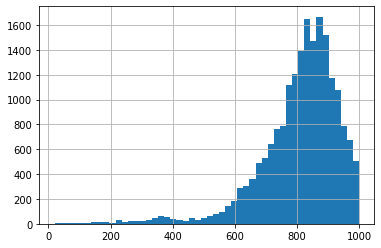

In [33]:
x_train['sequence'].apply(lambda x: len(list(x))).hist(bins=50)

In [34]:
maxLength = 1000

def getTruncatedPadded(text):
    l = len(text)
    if l > maxLength:
        text = text[:maxLength]
    if l < maxLength:
        text = text + 'N'*(maxLength-l)
    
    return text    

In [35]:
x_train['sequence'] = x_train['sequence'].apply(lambda x: getTruncatedPadded(x))

In [36]:
chars = {'A':[1,0,0,0], 'T':[0,1,0,0], 'C':[0,0,1,0], 'G':[0,0,0,1], 'N':[0,0,0,0]}

def oneHotText(text):
    return [chars[x] for x in list(text)]

In [37]:
X_train = []

for i , row in x_train.iterrows():
    r = oneHotText(row['sequence'])
    X_train.append(r)
    
X_train = np.array(X_train)

In [38]:
print(X_train.shape)

(19564, 1000, 4)


In [39]:
t = np.argmax(x_train[target].values, axis=1)

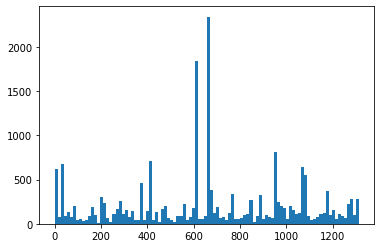

In [40]:
s = plt.hist(t, bins=100)[0]

In [41]:
x_train

,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,growth_strain_dh10b,growth_strain_dh5alpha,growth_strain_neb_stable,growth_strain_other,growth_strain_stbl3,growth_strain_top10,growth_strain_xl1_blue,growth_temp_30,growth_temp_37,growth_temp_other,selectable_markers_blasticidin,selectable_markers_his3,selectable_markers_hygromycin,selectable_markers_leu2,selectable_markers_neomycin,selectable_markers_other,selectable_markers_puromycin,selectable_markers_trp1,selectable_markers_ura3,selectable_markers_zeocin,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish,...,Z1C99MVU,Z1Y066QU,Z6LWLWFZ,Z7YFK3I0,Z7ZKDLZG,Z80NVAXF,Z8BWVZZX,ZAYLY2YU,ZB6DPIG5,ZB862XHR,ZBQD50GN,ZC07UYVV,ZCU48L3S,ZEAZQ1QQ,ZEB7PDQK,ZEBTRK7D,ZEJOQQJF,ZELU1VMX,ZFBSIW7Q,ZGY1YZ7P,ZH6LR5MO,ZIGUIE0J,ZIJRW95G,ZK6YBV02,ZLSXM0KN,ZMCRIYYJ,ZMEZU4BS,ZMUIMBDX,ZOI7FJEN,ZQ5A6IY9,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
sequence_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
XZ42B,GAAAGCTGAGCCTGCGACTCCCGCAGAAGCGGCGCAAAGCGACCGC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R95QA,TCGCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N4W48,TCGGATCTGATCAAGGTCGTGGGATCCCCGGAATTCCCGGGTCGAC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FJEH1,CATGCATCTCTCAGTGCACTAAAGGGGGGATCCGATCTCAATATGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QLFUH,GCAACGGAATATCTTAGTGCACTAAGGGGGGATCCGATCTCAATAT...,1.0,0.0,0.0,0.

In [42]:
tmpVar = x_train[target].values

In [43]:
argm = np.argmax(tmpVar, axis=1).tolist()

tmpV = [0] * 1315

sortedArgm = sorted(set(argm))
for x in sortedArgm:
  tmpV[x] = argm.count(x)

maxV = max(tmpV)


d = {}
for x in range(0,1315):
    if tmpV[x] != 0 and x in sortedArgm:
      if tmpV[x] != maxV:
        d[x] = 2*maxV/tmpV[x]
      else:
        d[x] = 1.0
    else:
      d[x] = 0.0

print(len(d.keys()))
print(d)



1315
{0: 1462.0, 1: 0.0, 2: 0.0, 3: 2193.0, 4: 626.5714285714286, 5: 0.0, 6: 0.0, 7: 0.0, 8: 9.061983471074381, 9: 548.25, 10: 109.65, 11: 313.2857142857143, 12: 74.33898305084746, 13: 2193.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 151.24137931034483, 18: 1096.5, 19: 0.0, 20: 1462.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 4386.0, 26: 125.31428571428572, 27: 731.0, 28: 4386.0, 29: 102.0, 30: 2193.0, 31: 7.641114982578397, 32: 731.0, 33: 487.3333333333333, 34: 4386.0, 35: 274.125, 36: 0.0, 37: 0.0, 38: 337.38461538461536, 39: 731.0, 40: 0.0, 41: 0.0, 42: 2193.0, 43: 365.5, 44: 2193.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 104.42857142857143, 49: 151.24137931034483, 50: 0.0, 51: 0.0, 52: 0.0, 53: 2193.0, 54: 104.42857142857143, 55: 487.3333333333333, 56: 0.0, 57: 0.0, 58: 1096.5, 59: 162.44444444444446, 60: 548.25, 61: 0.0, 62: 398.72727272727275, 63: 0.0, 64: 292.4, 65: 258.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 2193.0, 71: 365.5, 72: 731.0, 73: 146.2, 74: 731.0, 75: 258.0, 76: 0.0, 77: 0.0, 78: 0

In [44]:
valsx = [int(x) for x in d.keys()]

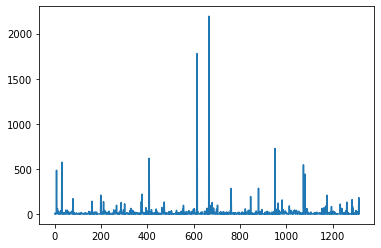

In [46]:

plt.plot(valsx, tmpV)
plt.show()

IndexError: ignored

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, 
                                                    x_train[target].values, 
                                                    test_size = 0.2, 
                                                    random_state=42)

In [48]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(15651, 1000, 4)
(15651, 1314)
(3913, 1000, 4)
(3913, 1314)


In [49]:
print(sum(X_train[0]))
print(sum(X_test[0]))
print(Y_train[0])
print(Y_test[0])

[298 238 203 228]
[196 163 245 260]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [82]:
model = tf.keras.Sequential([
    tf.keras.layers.Convolution1D(input_shape=(1000,4), filters=8, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Convolution1D(filters=8, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1314, activation='softmax'),
])

In [83]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-2), metrics=['categorical_accuracy'])

In [85]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 998, 8)            104       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 249, 8)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 247, 8)            200       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 61, 8)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 488)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               125184    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)              

In [ ]:
!pip install keras-lr-finder

Epoch 1/5
16/16 [==============================] - 1s 33ms/step - loss: 7.3611 - categorical_accuracy: 5.1115e-04
Epoch 2/5
16/16 [==============================] - 0s 28ms/step - loss: 6.7171 - categorical_accuracy: 0.0603
Epoch 3/5
16/16 [==============================] - 0s 25ms/step - loss: 5.4194 - categorical_accuracy: 0.0785
Epoch 4/5
16/16 [==============================] - 0s 27ms/step - loss: 5.4413 - categorical_accuracy: 0.1039
Epoch 5/5
16/16 [==============================] - 0s 25ms/step - loss: 534.3657 - categorical_accuracy: 0.0679


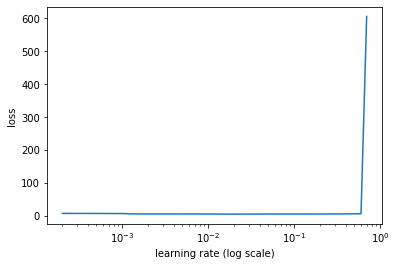

In [86]:
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)

lr_finder.find(X_train, Y_train, start_lr=0.00001, end_lr=1, batch_size=1024, epochs=5)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [87]:
hist = model.fit(X_train, Y_train, epochs=100, batch_size=256, validation_data=(X_test, Y_test))

Epoch 1/100
62/62 [==============================] - 1s 14ms/step - loss: 5.2902 - categorical_accuracy: 0.0992 - val_loss: 4.8750 - val_categorical_accuracy: 0.1283
Epoch 2/100
62/62 [==============================] - 1s 11ms/step - loss: 4.6210 - categorical_accuracy: 0.2058 - val_loss: 4.3435 - val_categorical_accuracy: 0.2740
Epoch 3/100
62/62 [==============================] - 1s 10ms/step - loss: 4.2062 - categorical_accuracy: 0.2771 - val_loss: 4.1416 - val_categorical_accuracy: 0.2870
Epoch 4/100
62/62 [==============================] - 1s 10ms/step - loss: 3.9741 - categorical_accuracy: 0.3098 - val_loss: 3.9695 - val_categorical_accuracy: 0.3240
Epoch 5/100
62/62 [==============================] - 1s 10ms/step - loss: 3.7860 - categorical_accuracy: 0.3349 - val_loss: 3.8524 - val_categorical_accuracy: 0.3465
Epoch 6/100
62/62 [==============================] - 1s 10ms/step - loss: 3.6203 - categorical_accuracy: 0.3554 - val_loss: 3.8144 - val_categorical_accuracy: 0.3450
Epoc

In [84]:
#### helper plot function
def plot_acc_loss(history):
  plt.plot(history.history['categorical_accuracy'], label='acc')
  plt.plot(history.history['val_categorical_accuracy'], label='val_acc')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()


  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_los')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

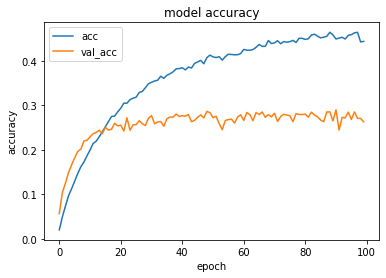

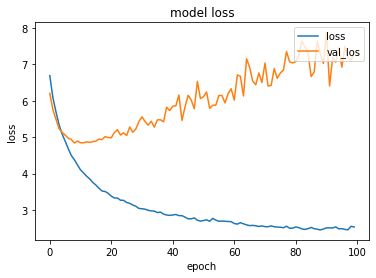

In [85]:
plot_acc_loss(hist)

In [ ]:
############################ submission phase TODO remove split use all data
submission_data = pd.read_csv(submission)

In [ ]:
x_test['Tdist'] = x_test['sequence'].map(lambda x: list(x).count('T')/len(x))
x_test['Adist'] = x_test['sequence'].map(lambda x: list(x).count('A')/len(x))
x_test['Cdist'] = x_test['sequence'].map(lambda x: list(x).count('C')/len(x))
x_test['Gdist'] = x_test['sequence'].map(lambda x: list(x).count('G')/len(x))
x_test['Ndist'] = x_test['sequence'].map(lambda x: list(x).count('N')/len(x))

In [ ]:
x_test

In [ ]:
test_cols = [x for x in x_test.columns if 'sequence' not in x]

In [ ]:
x_test[test_cols]

In [ ]:
res = model.predict(x_test[test_cols], batch_size=500)

In [ ]:
tmp = np.argmax(res, axis=1)

In [ ]:
output = np.zeros((len(tmp), tmp.max()+1))
output[np.arange(len(tmp)),tmp] = 1

In [ ]:
print(output.shape)
print(submission_data.loc[:, submission_data.columns != 'sequence_id'].shape)

In [ ]:
submission_data.loc[:, submission_data.columns != 'sequence_id'] = output

In [ ]:
submission_data.to_csv(submission, index=False)

In [ ]:
submission_data